# ***KNN***

In [ ]:
# ============================
# IMPORTS
# ============================
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import random
import plotly.express as px

from tqdm import tqdm
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, label_binarize
from sklearn.naive_bayes import MultinomialNB
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, log_loss, roc_auc_score, roc_curve, auc
)

import lime.lime_tabular
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

import optuna
from optuna.pruners import MedianPruner
import optuna.visualization as vis
from sklearn.preprocessing import LabelEncoder

from reporte_metricas import ReporteMetricas
reporte = ReporteMetricas()

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [ ]:
# =======================
# LOAD DATA
# =======================
file_path = "../Datos_Saber_Pro_Preprocesed.csv"
df = pd.read_csv(file_path)
df = df.head(3000)
X = df.drop(columns=["MOD_INGLES_DESEM"])
y = df["MOD_INGLES_DESEM"]

categorical_features = X.select_dtypes(include='object').columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [3]:
from sklearn.base import BaseEstimator

class PartialFitPipeline(BaseEstimator):
    def __init__(self, preprocessor, classifier, classes):
        self.preprocessor = preprocessor
        self.classifier = classifier
        self.classes = classes
        self.is_fitted = False

    def partial_fit(self, X, y):
        if isinstance(X, np.ndarray):
            # Extraer columnas esperadas desde el ColumnTransformer
            all_features = []
            for name, _, cols in self.preprocessor.transformers:
                if isinstance(cols, list):
                    all_features.extend(cols)
            X = pd.DataFrame(X, columns=all_features)

        if not self.is_fitted:
            X_proc = self.preprocessor.fit_transform(X)
            self.is_fitted = True
        else:
            X_proc = self.preprocessor.transform(X)

        self.classifier.partial_fit(X_proc, y, classes=self.classes)
        return self

    def predict(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.classifier.predict(X_proc)

    def predict_proba(self, X):
        X_proc = self.preprocessor.transform(X)
        return self.classifier.predict_proba(X_proc)

    def score(self, X, y):
        return self.classifier.score(self.preprocessor.transform(X), y)


In [5]:
le = LabelEncoder()
y = pd.Series(le.fit_transform(y), index=y.index)

class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Class mapping:", class_mapping)

Class mapping: {'-A1': 0, 'A1': 1, 'A2': 2, 'B1': 3, 'B2': 4}


In [6]:
df.shape

(3000, 23)

In [7]:
# ============================
# PATHS CONFIGURADOS PARA GUARDADO DE OBJETOS
# ============================
model_filename = r"C:/Users/alvar/Downloads/Pruebas ML/Models/best_NB_partial_model.pkl"
study_filename = r"C:/Users/alvar/Downloads/Pruebas ML/Models/optuna_study_NB_partial_nested.pkl"
metrics_filename = r"C:/Users/alvar/Downloads/Pruebas ML/Models/best_NB_partial_metrics.pkl"
fold_metrics_filename = r"C:/Users/alvar/Downloads/Pruebas ML/Models/NB_partial_folds_summary.csv"

In [8]:

# ============================
# EVALUATION FUNCTION
# ============================
def evaluate_model(model, X_data, y_data):
    y_pred = model.predict(X_data)
    y_proba = model.predict_proba(X_data)
    f1 = f1_score(y_data, y_pred, average='weighted')
    acc = accuracy_score(y_data, y_pred)
    loss = log_loss(y_data, y_proba, labels=np.unique(y))  # Asegura etiquetas
    auc = roc_auc_score(y_data, y_proba, multi_class='ovr', average='weighted')
    report = classification_report(y_data, y_pred)
    cm = confusion_matrix(y_data, y_pred)
    return f1, acc, loss, auc, report, cm, y_proba, y_pred

In [ ]:


def build_partial_fit_pipeline_naive_bayes(params, numeric_features, categorical_features, y):
    preprocessor = ColumnTransformer([
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', MinMaxScaler())
        ]), numeric_features),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='constant', fill_value='Sin Dato')),
            ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
        ]), categorical_features)
    ], verbose_feature_names_out=False)

    classifier = MultinomialNB(**params)
    return PartialFitPipeline(preprocessor=preprocessor, classifier=classifier, classes=np.unique(y))


In [11]:
# ============================
# FOLD METRIC SAVER
# ============================
def save_metrics_folds(folds_metrics: list, filename: str) -> pd.DataFrame:
    df = pd.DataFrame(folds_metrics)
    metric_cols = df.columns.drop('fold') if 'fold' in df.columns else df.columns
    mean_row = df[metric_cols].mean().to_dict()
    std_row = df[metric_cols].std().to_dict()
    mean_row['fold'] = 'mean'
    std_row['fold'] = 'std'
    df_final = pd.concat([df, pd.DataFrame([mean_row, std_row])], ignore_index=True)
    df_final.to_csv(filename, index=False)
    print(f"\n📁 Fold metrics + summary saved to: {filename}")
    return df_final

# ============================
# CONFUSION MATRIX PLOTTER
# ============================
def plot_confusion_matrix(cm, labels, title):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format="d")
    plt.title(title)
    plt.show()

In [12]:
# ============================
# LIME EXPLAINER BUILDER
# ============================
def get_lime_explainer(model_wrapper, X_train_raw, y_train_raw):
    X_transformed = model_wrapper.preprocessor.transform(X_train_raw)
    feature_names = model_wrapper.preprocessor.get_feature_names_out()
    class_names = np.unique(y_train_raw).astype(str)
    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=X_transformed,
        feature_names=feature_names,
        class_names=class_names,
        mode='classification'
    )
    return explainer, X_transformed

In [ ]:
# ============================
# OPTUNA INNER CV OPTIMIZATION
# ============================
def run_inner_optuna(X_inner, y_inner, numeric_features, categorical_features):
        X_inner = pd.DataFrame(X_inner)
        y_inner = pd.Series(y_inner)

        def objective(trial):
            params = {"alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True)}
            skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)
            scores = []
            for train_idx, val_idx in skf.split(X_inner, y_inner):
                X_t = X_inner.iloc[train_idx].copy()
                X_v = X_inner.iloc[val_idx].copy()
                y_t = y_inner.iloc[train_idx].copy()
                y_v = y_inner.iloc[val_idx].copy()
                model = build_partial_fit_pipeline_naive_bayes(params, numeric_features, categorical_features)
                batch_size = 1000
                for i in range(0, len(X_t), batch_size):
                    X_batch = X_t.iloc[i:i+batch_size].copy()
                    y_batch = y_t.iloc[i:i+batch_size]
                    model.partial_fit(X_batch, y_batch)
                y_pred = model.predict(X_v)
                scores.append(f1_score(y_v, y_pred, average='weighted'))
            return np.mean(scores)

        study = optuna.create_study(direction="maximize", pruner=MedianPruner())
        study.optimize(objective, n_trials=50, n_jobs=8)
        return study.best_params, study


In [ ]:
# ============================
# NESTED CV
# ============================
def nested_cv(X: pd.DataFrame, y: pd.Series, numeric_features: list, categorical_features: list):
    # Validación para asegurar columnas válidas
    if not numeric_features:
        numeric_features = []
    if not categorical_features:
        categorical_features = X.columns.tolist()
    visualizations = {}
    all_folds_metrics = []

    if os.path.exists(model_filename) and os.path.exists(metrics_filename):
        best_model = joblib.load(model_filename)
        best_metrics = joblib.load(metrics_filename)
        if "best_fold" in best_metrics:
            study_dt = joblib.load(study_filename)['studies'][best_metrics['best_fold']]
        else:
            study_dt = None
        if study_dt:
            visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
            visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
            visualizations['param_importances'] = vis.plot_param_importances(study_dt)
            f1_scores = [t.value for t in study_dt.trials]
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
            fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
            visualizations['f1_score_evolution'] = fig
        return best_model, best_metrics, study_dt, visualizations

    optuna_studies = []
    outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    best_f1 = -np.inf
    best_model = None
    best_metrics = {}

    for fold, (train_idx, test_idx) in tqdm(enumerate(outer_cv.split(X, y), 1), total=5, desc="Training folds"):
        X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
        y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

        # Split interno para validación
        X_tr, X_val, y_tr, y_val = train_test_split(
            X_train_fold, y_train_fold, test_size=0.2, stratify=y_train_fold, random_state=SEED)

        start_time = time.time()
        best_params, study = run_inner_optuna(X_tr, y_tr, numeric_features, categorical_features)
        elapsed = time.time() - start_time

        optuna_studies.append(study)

        # Inicializar modelo
        model = build_partial_fit_pipeline_naive_bayes(best_params, numeric_features, categorical_features)

        # Entrenamiento incremental en lotes
        batch_size = 1000
        for i in range(0, len(X_tr), batch_size):
            X_batch = X_tr.iloc[i:i+batch_size].copy()
            y_batch = y_tr.iloc[i:i+batch_size]
            model.partial_fit(X_batch, y_batch)

        # Evaluación
        f1_train, acc_train, loss_train, auc_train, report_train, cm_train, y_proba_train, y_train_pred = evaluate_model(model, X_tr, y_tr)
        f1_val, acc_val, loss_val, auc_val, report_val, cm_val, y_proba_val, y_val_pred = evaluate_model(model, X_val, y_val)
        f1_test, acc_test, loss_test, auc_test, report_test, cm_test, y_proba_test, y_test_pred = evaluate_model(model, X_test_fold, y_test_fold)

        fold_metrics = {
            "fold": fold,
            "f1_train": f1_train,
            "accuracy_train": acc_train,
            "log_loss_train": loss_train,
            "auc_train": auc_train,
            "f1_val": f1_val,
            "accuracy_val": acc_val,
            "log_loss_val": loss_val,
            "auc_val": auc_val,
            "f1_test": f1_test,
            "accuracy_test": acc_test,
            "log_loss_test": loss_test,
            "auc_test": auc_test
        }
        all_folds_metrics.append(fold_metrics)

        if f1_test > best_f1:
            best_f1 = f1_test
            best_model = model
            best_metrics = {
                **fold_metrics,
                "params": best_params,
                "labels": np.unique(y),
                "best_fold": fold - 1,
                "X_train_fold": X_tr,
                "y_train_fold": y_tr,
                "y_train_pred": y_train_pred,
                "y_train_true": y_tr,
                "y_proba_train": y_proba_train,
                "classification_report_train": report_train,
                "confusion_matrix_train": cm_train,
                "y_val_true": y_val,
                "y_val_pred": y_val_pred,
                "y_proba_val": y_proba_val,
                "classification_report_val": report_val,
                "confusion_matrix_val": cm_val,
                "y_test_fold": y_test_fold,
                "y_test_pred": y_test_pred,
                "y_proba_test": y_proba_test,
                "classification_report_test": report_test,
                "confusion_matrix_test": cm_test
            }

    joblib.dump(best_model, model_filename)
    joblib.dump({"studies": optuna_studies}, study_filename)
    joblib.dump(best_metrics, metrics_filename)
    df_folds = save_metrics_folds(all_folds_metrics, fold_metrics_filename)

    study_dt = optuna_studies[best_metrics['best_fold']]
    visualizations['optimization_history'] = vis.plot_optimization_history(study_dt)
    visualizations['parallel_coordinate'] = vis.plot_parallel_coordinate(study_dt)
    visualizations['param_importances'] = vis.plot_param_importances(study_dt)

    f1_scores = [t.value for t in study_dt.trials]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(len(f1_scores))), y=f1_scores, mode='lines+markers', name='F1-score'))
    fig.update_layout(title='F1-Score Evolution During Optuna Optimization', xaxis_title='Trial', yaxis_title='F1-Score', template='plotly_dark')
    visualizations['f1_score_evolution'] = fig

    return best_model, best_metrics, study_dt, visualizations

In [16]:
model, metrics, study, visualizations = nested_cv(X, y, numeric_features, categorical_features)


In [17]:
model

PartialFitPipeline(classes=array([0, 1, 2, 3, 4]),
                   classifier=MultinomialNB(alpha=3.9279634729279),
                   preprocessor=ColumnTransformer(transformers=[('num',
                                                                 Pipeline(steps=[('imputer',
                                                                                  SimpleImputer(strategy='median')),
                                                                                 ('scaler',
                                                                                  MinMaxScaler())]),
                                                                 []),
                                                                ('cat',
                                                                 Pipeline(steps=[('imputer',
                                                                                  SimpleImputer(fill_value='Sin '
                                                                                                           'Dato',
                                                                                                strategy='constant')),
                                                                                 ('ohe',
                                                                                  OneHotEncod...
                                                                  'ESTU_METODO_PRGM',
                                                                  'ESTU_VALORMATRICULAUNIVERSIDAD',
                                                                  'INST_CARACTER_ACADEMICO',
                                                                  'INST_ORIGEN',
                                                                  'ESTU_GENERO',
                                                                  'ESTU_NACIONALIDAD',
                                                                  'ESTU_HORASSEMANATRABAJA',
                                                                  'ESTU_PAGOMATRICULABECA',
                                                                  'ESTU_PAGOMATRICULACREDITO',
                                                                  'ESTU_PAGOMATRICULAPADRES',
                                                                  'ESTU_PAGOMATRICULAPROPIO',
                                                                  'ESTU_PRIVADO_LIBERTAD',
                                                                  'ESTU_DEPTO_RESIDE',
                                                                  'ESTU_DEPTO_PRESENTACION'])],
                                                  verbose_feature_names_out=False))

In [18]:
print(metrics['classification_report_val'])

              precision    recall  f1-score   support

           0       0.33      0.15      0.20        41
           1       0.27      0.19      0.22       100
           2       0.48      0.60      0.54       186
           3       0.41      0.44      0.42       105
           4       0.39      0.40      0.39        48

    accuracy                           0.42       480
   macro avg       0.38      0.35      0.36       480
weighted avg       0.40      0.42      0.40       480



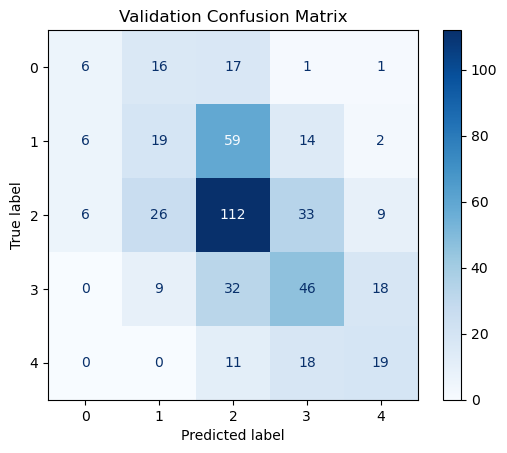

In [19]:
plot_confusion_matrix(metrics['confusion_matrix_val'], metrics['labels'], "Validation Confusion Matrix")

In [20]:
print(metrics['classification_report_test'])

              precision    recall  f1-score   support

           0       0.47      0.15      0.23        52
           1       0.33      0.26      0.29       124
           2       0.49      0.61      0.54       233
           3       0.32      0.33      0.33       132
           4       0.49      0.49      0.49        59

    accuracy                           0.42       600
   macro avg       0.42      0.37      0.38       600
weighted avg       0.42      0.42      0.41       600



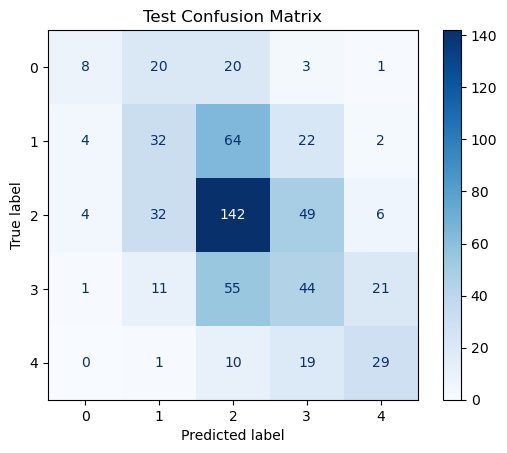

In [21]:
plot_confusion_matrix(metrics['confusion_matrix_test'], metrics['labels'], "Test Confusion Matrix")

--- Explanation for class 0 ---


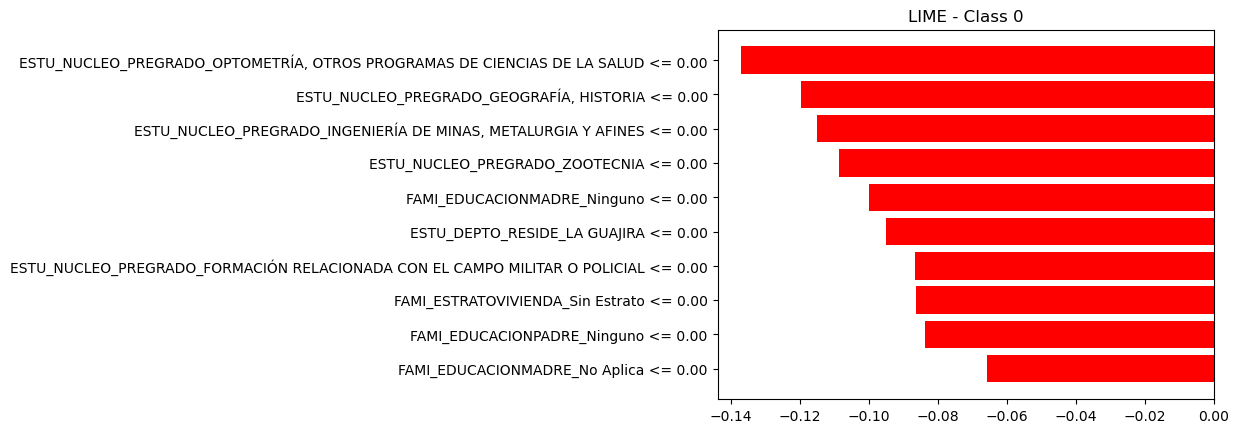

--- Explanation for class 1 ---


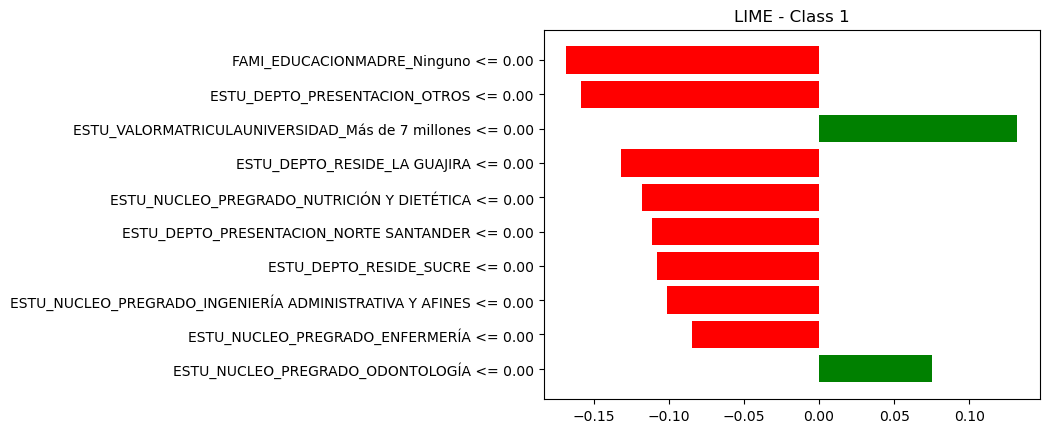

--- Explanation for class 2 ---


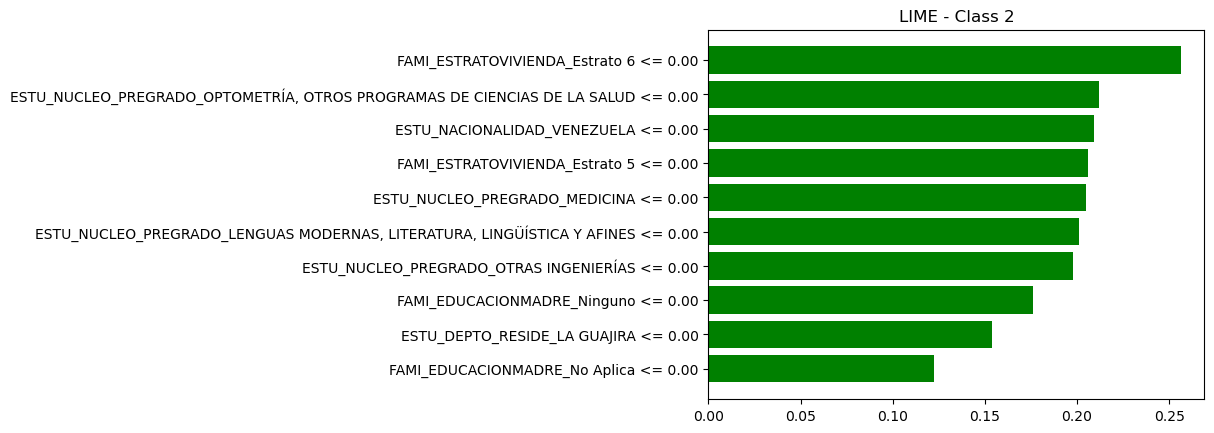

In [23]:
# ============================
# LIME EXPLANATION FOR Naive Bayes
# ============================

# Aplicar solo el preprocesamiento
X_transformed = model.preprocessor.transform(metrics['X_train_fold'])

# Función de predicción adaptada: NO volver a preprocesar
def predict_fn(x):
    return model.classifier.predict_proba(x)

# Obtener nombres de features y clases
feature_names = model.preprocessor.get_feature_names_out()
class_names = np.unique(metrics['y_train_fold']).astype(str)

# Instanciar LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_transformed,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

# Seleccionar instancia
instance = X_transformed[10]

# Explicar
exp = explainer.explain_instance(instance, predict_fn=predict_fn, labels=[0, 1, 2])

# Mostrar tabla
exp.show_in_notebook(show_table=True)

# Mostrar gráficas
for class_label in exp.available_labels():
    print(f"--- Explanation for class {class_label} ---")
    fig = exp.as_pyplot_figure(label=class_label)
    plt.title(f"LIME - Class {class_label}")
    plt.show()


In [24]:
visualizations['optimization_history']

In [25]:
visualizations['parallel_coordinate']

In [26]:
visualizations['f1_score_evolution']

In [27]:
visualizations['param_importances']

In [ ]:
reporte.save(metrics, model_name="NB_Partial")


✅ Report for model '_partial' saved:
   → CSV: ./Metrics\Metrics__partial.csv
   → JSON: ./Metrics\Metrics__partial.json


In [29]:
df = reporte.load()


✅ Loaded 2 report(s):
   → Models: ['NB', '_partial']
   → Types : ['train', 'val', 'test']


In [30]:
df.query("Model == 'KNN' and Type == 'train' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score


In [31]:
df.query("Model == 'KNN' and Type == 'val' and Class != 'global'").iloc[:, 0:6]

,Model,Type,Class,precision,recall,f1-score


In [32]:
df.query("Model == 'KNN' and Type == 'test' and Class != 'global'").iloc[:, 0:6]


,Model,Type,Class,precision,recall,f1-score


In [33]:
df.query("Model == 'KNN' and auc != '-'")[["Model", "Type", "accuracy", "log_loss", "auc"]]


,Model,Type,accuracy,log_loss,auc


In [34]:
df.query("Model == 'KNN' and Type == 'val' and Class	== 'global'")[["Model", "Type", "accuracy", "log_loss", "auc"]]

,Model,Type,accuracy,log_loss,auc


In [35]:
def plot_roc_multiclass(y_true, y_proba, class_labels, title="AUC-ROC Curve (Multiclass)"):
    # Binarize true labels
    y_bin = label_binarize(y_true, classes=class_labels)
    n_classes = len(class_labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"Class {class_labels[i]} (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], "k--", label="Random")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()


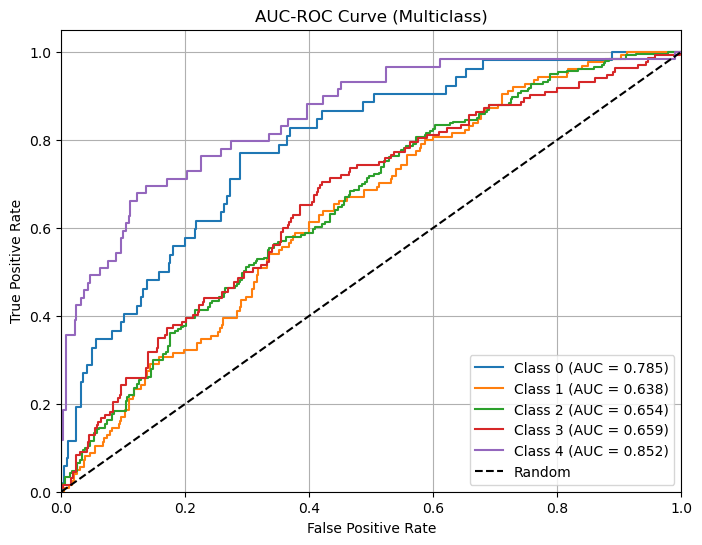

In [36]:
plot_roc_multiclass(
    y_true=metrics["y_test_fold"],
    y_proba=metrics["y_proba_test"],
    class_labels=metrics["labels"]
)

In [38]:
model.classifier.get_params()


{'alpha': 3.9279634729279,
 'class_prior': None,
 'fit_prior': True,
 'force_alpha': 'warn'}